<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/header.png" width="500"/>

## Goal of afternoon session

The goal of this session is to

> Excercise 1: Write your own convolutional layer from scratch.

> Excercise 2: Add batch normalisation and dropout to the `LeNet5` architecture shown in this morning's lecture, and train it to classify `FashionMNIST`.

> Excercise 3: Perform data augmentation and understand its effects.

> Excercise 4 (optional extension): interpret what the network has learned using the techniques from this morning's lecture.

In [2]:
import requests
from io import BytesIO
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Excercise 1: Write your own convolutional layer from scratch

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/conv-definition.png" width="90%"/>

Given the image below, and **without using PyTorch**:
1) define two filters: a horizontal edge detector and a vertical edge detector ([see here for help on the filter weights](https://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm))
2) convolve these two filters with the image
3) plot the convolved output images
4) check your function matches `torch.nn.functional.conv2d`

(256, 256)
[[  -2.    0.    0. ...   -8.   -2.    0.]
 [  -2.    0.    0. ...   -8.   -2.    0.]
 [  -5.   10.    4. ...   -2.   -2.   -3.]
 ...
 [  15.  -51. -108. ...   53.   55.  -41.]
 [  24.  -28. -133. ...   16.    6.  -74.]
 [  36.   75. -118. ...   17.   25.  -81.]]
[[   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [  15.    8.   -6. ...    4.   -2.    1.]
 ...
 [ -65.  -51.   -6. ... -197. -129.  -63.]
 [ -20.  -66. -109. ...  -38.  -20.   -4.]
 [  -2.  -71. -146. ...   83.   45.   17.]]
(254, 254) (254, 254)


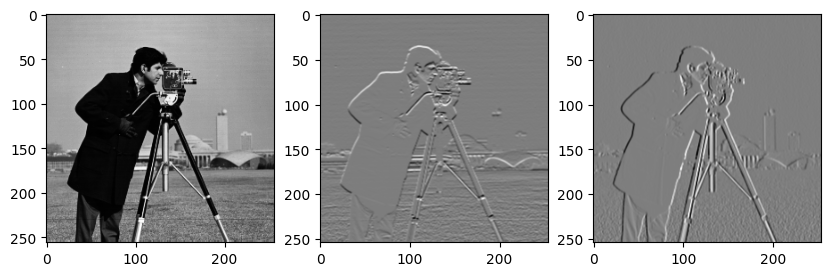

True
True


In [8]:
response = requests.get("https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/camera.tif")
x = np.array(Image.open(BytesIO(response.content)), dtype=np.float32)
print(x.shape)

# TODO: define edge detector filters
# define的是Sobel Edge Detector
w_v = np.array([[-1,0,1],[-2,0,2],[-1,0,1]],dtype=np.float32)
w_h = np.array([[1,2,1],[0,0,0],[-1,-2,-1]],dtype=np.float32)

def conv2d(x, w):
    """2D convolution.
    x: Input image of shape (height, width)
    w: Filter/kernel of shape (filter_height, filter_width)
    returns h: Output image
    """
    # TODO: define conv2d function
    x_height, x_width = x.shape
    w_height, w_width = w.shape

    # 5-3+1=3, 5-2+1 = 4.      先研究余量，再+本身
    h_height = x_height - w_height + 1
    h_width = x_width - w_width + 1

    h = np.zeros([h_height, h_width])

    for i in range(h_height):
      for j in range(h_width):
        h[i,j] = np.sum(x[i:i+w_height, j:j+w_width] * w)

    return h

b = np.array([0])
def conv2d_bias(x, w, b):
    """2D convolution.
    x: Input image of shape (height, width)
    w: Filter/kernel of shape (filter_height, filter_width)
    returns h: Output image
    """
    # TODO: define conv2d function
    x_height, x_width = x.shape
    w_height, w_width = w.shape

    # 5-3+1=3, 5-2+1 = 4.      先研究余量，再+本身
    h_height = x_height - w_height + 1
    h_width = x_width - w_width + 1

    h = np.zeros([h_height, h_width])

    for i in range(h_height):
      for j in range(h_width):
        h[i,j] = np.sum(x[i:i+w_height, j:j+w_width] * w) + b

    return h

# TODO: plot the convolved output images
h_v = conv2d(x, w_v)
print(h_v)
h_h = conv2d(x, w_h)
print(h_h)

print(h_h.shape, h_v.shape)
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(x, cmap="grey")
plt.subplot(1,3,2)
plt.imshow(h_h, cmap="grey")
plt.subplot(1,3,3)
plt.imshow(h_v, cmap="grey")
plt.show()



# TODO: check your function matches `torch.nn.functional.conv2d`
print(np.allclose(h_h, torch.nn.functional.conv2d(torch.tensor(x).view(1,256,256),torch.tensor(w_h).view(1,1,3,3))))
print(np.allclose(h_v, torch.nn.functional.conv2d(torch.tensor(x).view(1,256,256),torch.tensor(w_v).view(1,1,3,3))))

# Excercise 2: Add batch normalisation and dropout to the `LeNet5` architecture shown in this morning's lecture, and train it to classify `FashionMNIST`

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/lenet5.png" width="100%"/>

100%|██████████| 26.4M/26.4M [00:01<00:00, 21.2MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 351kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 6.26MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 18.6MB/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

60000 images in training dataset
10000 images in test dataset


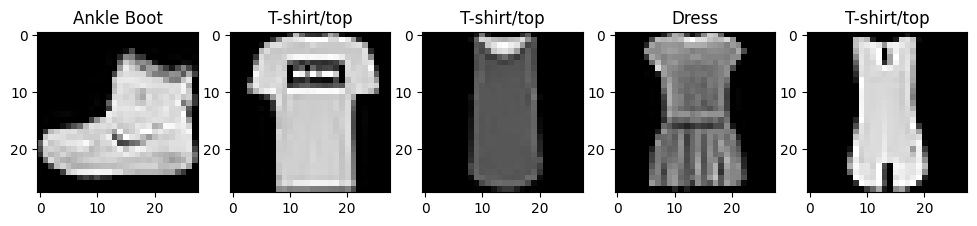

In [9]:
# download the FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
train_dataset = datasets.FashionMNIST('./', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./', train=False, download=True, transform=transform)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# plot some example images
print(f"{len(train_dataset)} images in training dataset")
print(f"{len(test_dataset)} images in test dataset")
plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.title(classes[train_dataset[i][1]])
    plt.imshow(train_dataset[i][0][0], cmap="grey")
plt.show()

1. First, train the same LeNet5 shown in this morning's lecture to classify the FashionMNIST dataset. Use the same hyperparameters (batch size, optimizer, learning rate etc) as the lecture.
2. Then, add batch normalisation and dropout after each convolutional layer. Retrain the network, and compare performance with the standard LeNet5.
3. What other changes you could make to the architecture / hyperparameters to improve performance?

Train Epoch: 0 [0/60000]	Loss: 2.320471
Train Epoch: 0 [6400/60000]	Loss: 0.761545
Train Epoch: 0 [12800/60000]	Loss: 0.399733
Train Epoch: 0 [19200/60000]	Loss: 0.596315
Train Epoch: 0 [25600/60000]	Loss: 0.528061
Train Epoch: 0 [32000/60000]	Loss: 0.567223
Train Epoch: 0 [38400/60000]	Loss: 0.491977
Train Epoch: 0 [44800/60000]	Loss: 0.642414
Train Epoch: 0 [51200/60000]	Loss: 0.614658
Train Epoch: 0 [57600/60000]	Loss: 0.428707
tensor([[-1.7150e+01, -2.1834e+01, -1.7347e+01, -1.5566e+01, -1.5443e+01,
         -8.7560e+00, -1.6189e+01, -5.6012e+00, -1.0395e+01, -3.8894e-03]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 10])
LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l5): Linear(in_features=400, out_features=10, bias=

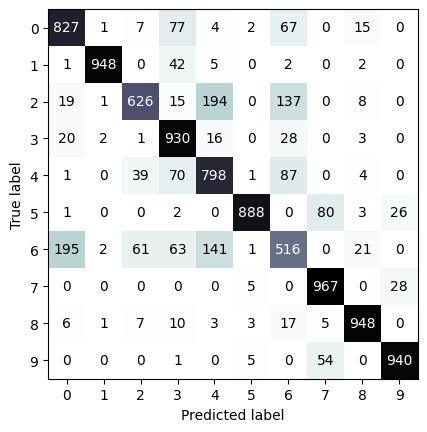

Train Epoch: 0 [0/60000]	Loss: 2.519491
Train Epoch: 0 [6400/60000]	Loss: 0.679644
Train Epoch: 0 [12800/60000]	Loss: 0.346575
Train Epoch: 0 [19200/60000]	Loss: 0.626621
Train Epoch: 0 [25600/60000]	Loss: 0.607489
Train Epoch: 0 [32000/60000]	Loss: 0.552206
Train Epoch: 0 [38400/60000]	Loss: 0.396247
Train Epoch: 0 [44800/60000]	Loss: 0.627660
Train Epoch: 0 [51200/60000]	Loss: 0.588483
Train Epoch: 0 [57600/60000]	Loss: 0.420028
Train Epoch: 1 [0/60000]	Loss: 0.300473
Train Epoch: 1 [6400/60000]	Loss: 0.498441
Train Epoch: 1 [12800/60000]	Loss: 0.233120
Train Epoch: 1 [19200/60000]	Loss: 0.402357
Train Epoch: 1 [25600/60000]	Loss: 0.416046
Train Epoch: 1 [32000/60000]	Loss: 0.530965
Train Epoch: 1 [38400/60000]	Loss: 0.310575
Train Epoch: 1 [44800/60000]	Loss: 0.570035
Train Epoch: 1 [51200/60000]	Loss: 0.461550
Train Epoch: 1 [57600/60000]	Loss: 0.398362
Train Epoch: 2 [0/60000]	Loss: 0.255262
Train Epoch: 2 [6400/60000]	Loss: 0.417666
Train Epoch: 2 [12800/60000]	Loss: 0.260236
Tra

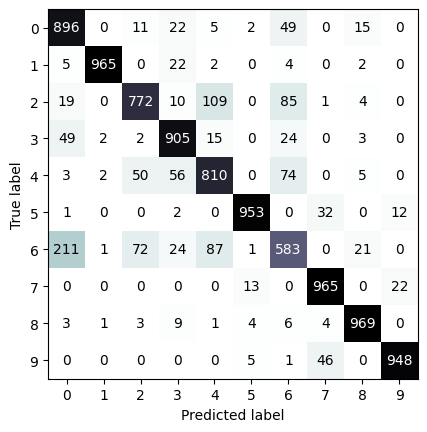

In [10]:
# TODO: train the same LeNet5 shown in this morning's lecture to classify the FashionMNIST dataset.
# Use the same hyperparameters (batch size, optimizer, learning rate etc) as the lecture.
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        #TODO: define the LeNet5 layers
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2) # define a 2D convolutional layer
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)               # define a maxpool layer
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)           # another 2D convolutional layer
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)               # another maxpool layer
        self.l5 = nn.Linear(16*5*5, 10)                               # linear classification head
        self.log_softmax = torch.nn.LogSoftmax(dim=1)                 # (log) softmax output
        self.act = nn.ReLU()                                          # activation function

    def forward(self, x):

        # TODO: define the forward network function
        x = self.act(self.c1(x))                                      # activate pass through the first layer
        #print(x.shape)
        x = self.act(self.s2(x))                                      # activate pass through the second layer
        #print(x.shape)
        x = self.act(self.c3(x))                                      # activate pass through the third layer
        #print(x.shape)
        x = self.act(self.s4(x))                                      # activate pass through the fourth layer
        #print(x.shape)
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))                 # flatten inputs for linear layer
        x = self.l5(x)                                                # linear classification head
        x = self.log_softmax(x)                                       # output (log) softmax probabilities of each class
        return x

    def middle_feature(self, x):
        x = self.act(self.c1(x))
        x = self.act(self.s2(x))
        x = self.c3(x)
        return x

torch.manual_seed(123)
model = LeNet5()

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=256)

def train(model, train_loader, epochs=1):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.NLLLoss()# negative log likelihood loss
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):

            # TODO: optimise model
            optimizer.zero_grad()
            logp = model(data)
            loss = criterion(logp, target)
            loss.backward()
            optimizer.step()


            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

train(model, train_loader)
y = model(train_dataset[0][0].unsqueeze(0))
print(y)
print(y.shape)
print(model)

def evaluate(model, test_loader):
    "Get model predictions on test dataset"
    model.eval()
    preds, targets = [],[]
    with torch.no_grad():
        for data, target in test_loader:

            # TODO: compute the class probability predictions of the model, and get the most likely class
            logp = model(data)
            pred = logp.argmax(dim=1)# get the index of the max log-probability

            preds.append(pred)
            targets.append(target)
    preds = torch.concat(preds)
    targets = torch.concat(targets)

    # TODO: compute the average accuracy on the test set
    correct = preds.eq(targets).sum().item()
    print('\nTest set: Average Accuracy: {}/{} ({:.0f}%)\n'.format(
          correct, len(test_loader.dataset), 100.*correct/len(test_loader.dataset)))

    plt.figure()
    ConfusionMatrixDisplay.from_predictions(targets, preds, ax=plt.gca(), colorbar=False, cmap='bone_r')
    plt.show()

evaluate(model, test_loader)

# TODO: check the output dimensions makes sense, and print the shapes of the hidden layer outputs



# TODO: Add batch normalisation and dropout after each convolutional layer.
# Retrain the network, and compare performance with the standard LeNet5.
class LeNet5_bndr(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2) # define a 2D convolutional layer
        self.b1 = nn.BatchNorm2d(6)
        self.d1 = nn.Dropout2d(p=0.1)
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)               # define a maxpool layer
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)           # another 2D convolutional layer
        self.b3 = nn.BatchNorm2d(16)
        self.d3 = nn.Dropout2d(p=0.1)
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)               # another maxpool layer
        self.l5 = nn.Linear(16*5*5, 10)                               # linear classification head
        self.log_softmax = torch.nn.LogSoftmax(dim=1)                 # (log) softmax output
        self.act = nn.ReLU()                                          # activation function

    def forward(self, x):
        x = self.d1(self.act(self.b1(self.c1(x))))                    # activate pass through the first layer
        x = self.act(self.s2(x))                                      # activate pass through the second layer
        x = self.d3(self.act(self.b3(self.c3(x))))                    # activate pass through the third layer
        x = self.act(self.s4(x))                                      # activate pass through the fourth layer
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))                 # flatten inputs for linear layer
        x = self.l5(x)                                                # linear classification head
        x = self.log_softmax(x)                                       # output (log) softmax probabilities of each class
        return x

torch.manual_seed(123)
model2 = LeNet5_bndr()
train(model2, train_loader, 3)
evaluate(model2, test_loader)

# Excercise 3: Perform data augmentation and understand its effects

Using data augmentation can help improve the accuracy of the model and reduce the likelihood of overfitting.

We can easily perform data augmentations by using PyTorch **[transforms](https://pytorch.org/vision/stable/transforms.html#v1-api-reference)** in our training `Dataset` class.

Tasks:
1. Add a transform to `train_dataset` which randomly rotates training images by 10 degrees below ([hint](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomRotation.html#torchvision.transforms.RandomRotation)), and plot some images to check the rotation is being applied
2. Retrain your models with this transformation. What differences do you observe?
3. Try adding other transformations too (e.g. random cropping, flipping, and gaussian blur)

In [ ]:
# TODO: Add a transform to `train_dataset` which randomly rotates training images by 10 degrees below,
# and plot some images to check the rotation is being applied
transform_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.Normalize((0.5,), (0.5,)),
    ])

train_dataset_augmented = datasets.FashionMNIST('./', train=True, download=True, transform=transform_augmented)

plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.title(classes[train_dataset_augmented[i][1]])
    plt.imshow(train_dataset_augmented[i][0][0], cmap="grey")
plt.show()



# TODO: Retrain your models with this transformation. What differences do you observe?


# TODO: Try adding other transformations too (e.g. random cropping, flipping, and gaussian blur)


# Excercise 4 (optional extension): interpret what the network has learned using the techniques from this morning's lecture

Select a test image, and then plot 1) the feature maps (outputs) of the first convolutional layer and 2) the saliency of the image to its class prediction.

In [ ]:
# TODO: Select a test image, and then plot
# 1) the feature maps (outputs) of the first convolutional layer and
# 2) the saliency of the image to its class prediction

